# Load

Final cleaned merged dataset is loaded into gold folder.

## Configuration

In [50]:
import os
from google.colab import drive
# Check if Google Drive is already mounted, mount otherwise
if not os.path.ismount('/content/drive'):
    print("Google Drive is not mounted yet. Mounting...")
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

Google Drive is already mounted.


In [51]:
import sys
sys.path.append('/content/drive/MyDrive/DataLife/modules')
import utils

In [52]:
#import re
#import glob
import pandas as pd
#from datetime import datetime

In [53]:
silver_path = "/content/drive/MyDrive/DataLife/data/silver"
gold_path = "/content/drive/MyDrive/DataLife/data/gold"

airport_silver_path = f"{silver_path}/fact_airport_traffic.parquet"
gdp_silver_path = f"{silver_path}/fact_gdp_worldbank.parquet"
co2_silver_path = f"{silver_path}/fact_co2_emissions.parquet"

## Airport Traffic

In [54]:
df_flights = pd.read_parquet(airport_silver_path)

In [55]:
# Count unique values in column STATE_NAME
num_unique_countries = df_flights['STATE_NAME'].nunique()
print(f"Number of unique countries: {num_unique_countries}")

Number of unique countries: 43


In [56]:
# Get all unique countries and years from df_flights_final
all_countries = df_flights['STATE_NAME'].unique()
all_years = df_flights['YEAR'].unique()

# Create a complete set of all expected country-year combinations
from itertools import product
expected_combinations = set(product(all_countries, all_years))

# Create a set of existing country-year combinations from df_flights
existing_combinations = set(zip(df_flights['STATE_NAME'], df_flights['YEAR']))

# Find the missing combinations
missing_combinations = sorted(list(expected_combinations - existing_combinations))

if missing_combinations:
    print(f"Missing GDP data for the following country-year combinations ({len(missing_combinations)} missing):")
    for country, year in missing_combinations:
        print(f"  - Country: {country}, Year: {year}")
else:
    print("No missing GDP data found for any country-year combination in the current dataset.")

Missing GDP data for the following country-year combinations (14 missing):
  - Country: Iceland, Year: 2016
  - Country: Iceland, Year: 2017
  - Country: Iceland, Year: 2018
  - Country: Iceland, Year: 2019
  - Country: Iceland, Year: 2020
  - Country: Iceland, Year: 2021
  - Country: Iceland, Year: 2022
  - Country: Iceland, Year: 2023
  - Country: Israel, Year: 2016
  - Country: Israel, Year: 2017
  - Country: Morocco, Year: 2016
  - Country: Morocco, Year: 2017
  - Country: Ukraine, Year: 2024
  - Country: Ukraine, Year: 2025


In [57]:
# Delete countries from which we have missing information
countries_to_exclude = ['Iceland', 'Israel', 'Morocco', 'Ukraine']
df_flights = df_flights[~df_flights['STATE_NAME'].isin(countries_to_exclude)]

In [58]:
# Filter only required columns for our analysis
df_flights_filtered = df_flights[['YEAR','STATE_NAME','FLT_TOT_1']]

In [59]:
# Aggregate total of flights for Country and Year
df_flights_agg = df_flights_filtered.groupby(['STATE_NAME', 'YEAR']).agg({'FLT_TOT_1': 'sum'}).reset_index()

In [60]:
# Standarize names of columns and rename Turkey
df_flights_final = df_flights_agg.rename(columns={'STATE_NAME': 'country', 'YEAR': 'year', 'FLT_TOT_1': 'total_flights'}).replace({"Türkiye":"Turkiye"})

## GDP Worldbank

In [61]:
df_gdp = pd.read_parquet(gdp_silver_path)

In [62]:
# Check if countries have different names on both datasets
countries_gdp = set(df_gdp['Country Name'].unique())
countries_flights = set(df_flights_final['country'].unique())
print(f"Countries in Flights dataset but not in GDP dataset: {countries_flights - countries_gdp}")

Countries in Flights dataset but not in GDP dataset: {'Slovakia', 'Czech Republic', 'Republic of North Macedonia'}


In [63]:
# Standardize country names for joins; by default, we will use the naming convention from the flights dataset.
country_name_mapping = {
    'Czechia': 'Czech Republic',
    'North Macedonia': 'Republic of North Macedonia',
    'Slovak Republic': 'Slovakia'
}
df_gdp['Country Name'] = df_gdp['Country Name'].replace(country_name_mapping)

# Re-check the country differences after replacement
countries_gdp = set(df_gdp['Country Name'].unique())
countries_flights = set(df_flights_final['country'].unique())

print(f"Countries in Flights but not in GDP: {countries_flights - countries_gdp}")

Countries in Flights but not in GDP: set()


In [64]:
# Filter only by European Countries from whose we have information about flights.
df_gdp_filtered = df_gdp[df_gdp['Country Name'].isin(countries_flights)]

In [65]:
# Melt dataframe to copy structure from flights dataset
df_gdp_melted = df_gdp_filtered.melt(id_vars=['Country Name'], var_name='year', value_name='gdp')

# Convert 'year' column to integer type
df_gdp_melted['year'] = df_gdp_melted['year'].astype(int)

In [66]:
# Rename 'Country Name' to 'country'
df_gdp_final = df_gdp_melted.rename(columns={'Country Name': 'country'})

## Join GDP - Airport Traffic data and adapt for the final merge with CO$_2$ emissions dataset

In [67]:
# Merge three DataFrames on 'country' and 'year'
df_final = pd.merge(df_flights_final, df_gdp_final, on=['country', 'year'], how='inner')

In [68]:
# Adapt dataset for comparison with CO_2 emissions dataset

# 1. Filter the rows for the two countries
target_countries = ['Serbia', 'Montenegro']
subset = df_final[df_final['country'].isin(target_countries)]

# 2. Group by 'year' and sum the numeric columns ('total_flights' and 'gdp')
combined_rows = subset.groupby('year', as_index=False)[['total_flights', 'gdp']].sum()

# 3. Set the new country name
combined_rows['country'] = 'Serbia and Montenegro'

# 4. Remove the original Serbia and Montenegro rows from the main dataframe
df_final = df_final[~df_final['country'].isin(target_countries)]

# 5. Append the new combined rows to the dataframe
df_final = pd.concat([df_final, combined_rows], ignore_index=True)

# Final: Sort by country and year to keep the dataframe organized
df_final = df_final.sort_values(['country', 'year']).reset_index(drop=True)

## CO$_2$ Emissions

In [69]:
df_co2 = pd.read_parquet(co2_silver_path)

In [70]:
# Check if countries have different names on both datasets
countries_co2 = set(df_co2['Country'].unique())
countries = set(df_final['country'].unique())
print(f"Countries in Flights dataset but not in CO2 emissions dataset: {countries - countries_co2}")

Countries in Flights dataset but not in CO2 emissions dataset: {'Spain', 'France', 'Turkiye', 'Switzerland', 'Italy', 'Republic of North Macedonia', 'Czech Republic'}


In [71]:
# Standardize country names for joins; by default, we will use the naming convention from the flights dataset
country_name_mapping = {
    'Czechia': 'Czech Republic',
    'North Macedonia': 'Republic of North Macedonia',
    'Türkiye': 'Turkiye',
    'Spain and Andorra': 'Spain',
    'France and Monaco': 'France',
    'Switzerland and Liechtenstein': 'Switzerland',
    'Italy, San Marino and the Holy See': 'Italy'
}
df_co2['Country'] = df_co2['Country'].replace(country_name_mapping)

# Re-check the country differences after replacement
countries_co2 = set(df_co2['Country'].unique())
countries = set(df_final['country'].unique())
print(f"Countries in merged dataset but not in CO2 emissions dataset: {countries - countries_co2}")

Countries in merged dataset but not in CO2 emissions dataset: set()


In [72]:
# Filter only by European Countries from whose we have information about flights
df_co2_filtered = df_co2[df_co2['Country'].isin(countries)]

In [73]:
# Melt dataframe to copy structure from flights dataset
df_co2_melted = df_co2_filtered.melt(id_vars=['Country'], var_name='year', value_name='fossil_co2_emissions')

# Convert 'year' column to integer type
df_co2_melted['year'] = df_co2_melted['year'].astype(int)

In [74]:
# Rename columns to follow convention
df_co2_final = df_co2_melted.rename(columns={'Country': 'country'})

## Final Merge

In [75]:
# Final merge with CO_2 emissions dataset
df_final = pd.merge(df_final, df_co2_final, on=['country', 'year'], how='inner')

In [76]:
utils.df_to_csv(df_final, f"final_dataset.csv", gold_path)

File correctly saved at: /content/drive/MyDrive/DataLife/data/gold/final_dataset.csv


## Graphs (test)

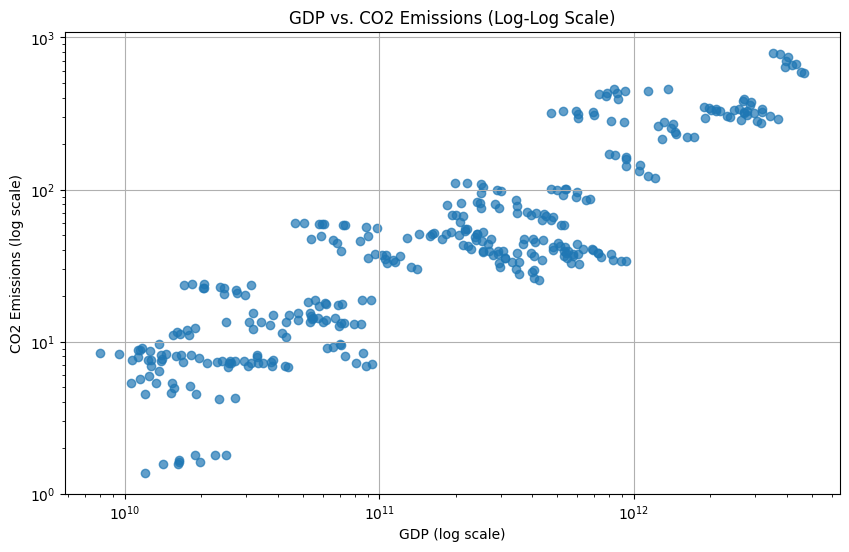

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_final['gdp'], df_final['fossil_co2_emissions'], alpha=0.7)
plt.title('GDP vs. CO2 Emissions (Log-Log Scale)')
plt.xlabel('GDP (log scale)')
plt.ylabel('CO2 Emissions (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [78]:
df_comparison = df_final.copy()

In [79]:
df_comparison['co2/gdp'] = df_comparison['fossil_co2_emissions']/df_comparison['gdp']
big5 = ['Germany', 'United Kingdom', 'France', 'Spain', 'Italy']
df_comparison = df_comparison[df_comparison['country'].isin(big5)]

In [87]:
df_comparison_sorted = df_comparison.sort_values(by='co2/gdp', ascending=True)
print("DataFrame sorted by co2/gdp (ascending order):")
display(df_comparison_sorted)

DataFrame sorted by co2/gdp (ascending order):


,country,year,total_flights,gdp,fossil_co2_emissions,co2/gdp
341,United Kingdom,2024,1985592,3.686033e+12,292.419359,7.933172e-11
116,France,2024,1707533,3.160443e+12,274.450524,8.683927e-11
340,United Kingdom,2023,1913086,3.420797e+12,304.786611,8.909814e-11
115,France,2023,1682535,3.056251e+12,284.154113,9.297474e-11
339,United Kingdom,2022,1680130,3.181244e+12,324.994856,1.021597e-10
338,United Kingdom,2021,811162,3.194559e+12,337.914843,1.057782e-10
113,France,2021,1124114,2.966434e+12,316.704417,1.067627e-10
112,France,2020,882700,2.647926e+12,287.086809,1.084195e-10
114,France,2022,1599812,2.794788e+12,307.680244,1.100907e-10
337,United Kingdom,2020,817196,2.724001e+12,319.696417,1.173628e-10


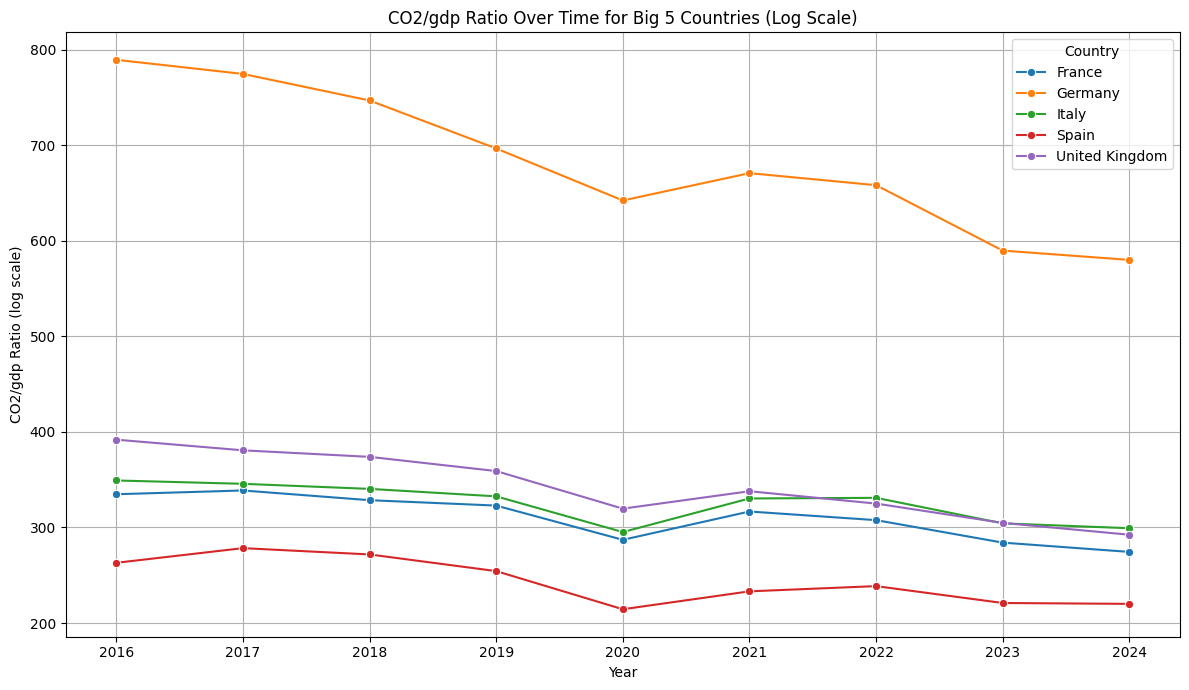

In [86]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_comparison, x='year', y='fossil_co2_emissions', hue='country', marker='o')
plt.title('CO2/gdp Ratio Over Time for Big 5 Countries (Log Scale)')
plt.xlabel('Year')
plt.ylabel('CO2/gdp Ratio (log scale)')
plt.grid(True)
plt.legend(title='Country')
plt.xticks(df_comparison['year'].unique())
plt.tight_layout()
plt.show()

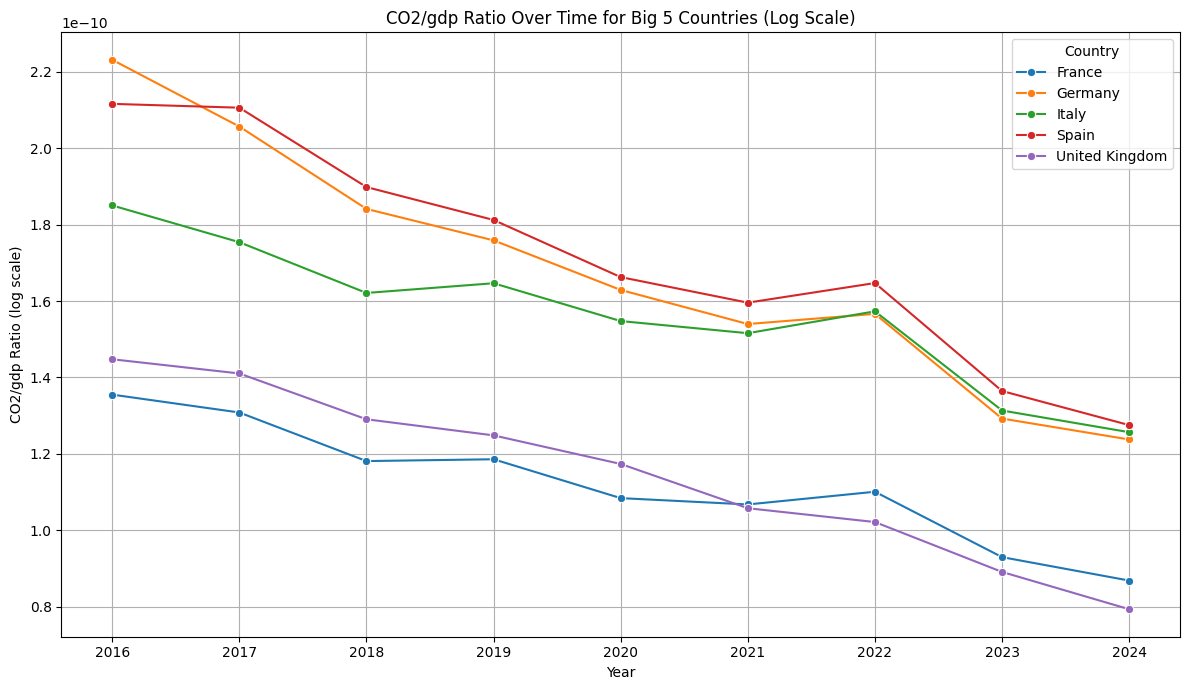

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_comparison, x='year', y='co2/gdp', hue='country', marker='o')
plt.title('CO2/gdp Ratio Over Time for Big 5 Countries (Log Scale)')
plt.xlabel('Year')
plt.ylabel('CO2/gdp Ratio (log scale)')
plt.grid(True)
plt.legend(title='Country')
plt.xticks(df_comparison['year'].unique())
plt.tight_layout()
plt.show()